# Análise de partidas de Xadrez (Lichess)


## Objetivo

O objetivo desta análise é explorar as características das partidas de xadrez e identificar os fatores chave que influenciam os resultados dos jogos, com foco em entender as relações entre as classificações dos jogadores, o tempo de jogo e as decisões estratégicas. Ao analisar um conjunto de dados de partidas de xadrez, este estudo visa fornecer insights sobre o jogo de xadrez e informar estratégias para melhoria.

## Sobre o Conjunto de Dados

**Informações Gerais**

Este conjunto de dados contém aproximadamente 20.000 partidas coletadas de uma seleção de usuários do site Lichess.org. Os dados foram obtidos utilizando a API do Lichess, que permite a recuperação do histórico de partidas de qualquer usuário. Uma limpeza de dados já foi realizada, e pode ser consultada em outro notebook: [data_cleaning.ipynb](1-data_cleaning.ipynb). Após a limpeza de dados, conjunto inclui as seguintes colunas:

- `turns`: Número de movimentos
- `victory_status`: Status da partida
- `winner`: Vencedor
- `white_rating`: Rating do jogador com peças brancas
- `black_rating`: Rating do jogador com peças pretas
- `opening_name`: Nome da abertura
- `opening_ply`: Número de movimentos na fase de abertura
- `increment_code`: Tempo no relógio

Link para o conjunto de dados no Kaggle: [Lichess Dataset](https://www.kaggle.com/datasets/datasnaek/chess/data).

## Importando bibliotecas e Dados

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [46]:
# Carregando os dados
df = pd.read_csv('data/games_clean.csv')
df.head()

,turns,victory_status,winner,white_rating,black_rating,opening_name,opening_ply,increment_code
0,13,outoftime,white,1500,1191,Slav Defense: Exchange Variation,5,15+2
1,16,resign,black,1322,1261,Nimzowitsch Defense: Kennedy Variation,4,5+10
2,61,mate,white,1496,1500,King's Pawn Game: Leonardis Variation,3,5+10
3,61,mate,white,1439,1454,Queen's Pawn Game: Zukertort Variation,3,20+0
4,95,mate,white,1523,1469,Philidor Defense,5,30+3


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19429 entries, 0 to 19428
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   turns           19429 non-null  int64 
 1   victory_status  19429 non-null  object
 2   winner          19429 non-null  object
 3   white_rating    19429 non-null  int64 
 4   black_rating    19429 non-null  int64 
 5   opening_name    19429 non-null  object
 6   opening_ply     19429 non-null  int64 
 7   increment_code  19429 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.2+ MB


In [48]:
df.describe()

,turns,white_rating,black_rating,opening_ply
count,19429.000000,19429.000000,19429.000000,19429.000000
mean,61.061249,1597.697874,1589.905759,4.836996
std,33.141354,288.138194,288.826834,2.788092
min,3.000000,784.000000,789.000000,1.000000
25%,38.000000,1401.000000,1395.000000,3.000000
50%,56.000000,1568.000000,1563.000000,4.000000
75%,79.000000,1792.000000,1784.000000,6.000000
max,349.000000,2700.000000,2621.000000,28.000000


***
## Análise Exploratória dos Dados (EDA)

##### Cores para os gráficos

In [49]:
# cores peças Brancas, Pretas e Empate
colorB, colorD, colorW = ['#2D1803', '#7F6647', '#D2B48C']

# escala de cores madeira
wood_colors = ['#2E1B0F', '#52372A', '#6D573A', '#7F6647', '#907A4B', '#A6905F', '#B89F72', '#C7A978', '#D2B48C']

***
### Martiz de Correlação

In [50]:
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,turns,white_rating,black_rating,opening_ply
turns,1.000000,0.122851,0.154228,0.035919
white_rating,0.122851,1.000000,0.636065,0.277654
black_rating,0.154228,0.636065,1.000000,0.253412
opening_ply,0.035919,0.277654,0.253412,1.000000


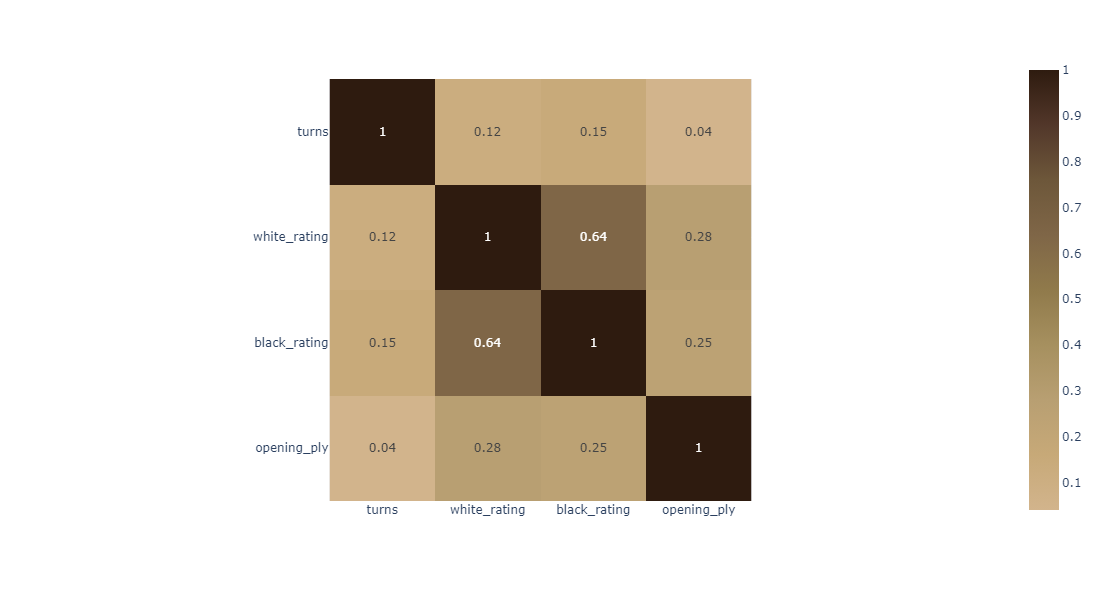

In [51]:
# Heatmap
px.imshow(correlation_matrix.round(2), 
          width=600, height=600,
          text_auto=True,
          # sequência de cores ao contrário
          color_continuous_scale=wood_colors[::-1]
         )

A análise da matriz de correlação revela que enquanto as classificações dos jogadores (white_rating e black_rating) têm uma correlação moderada entre si, a relação dessas classificações com o número de jogadas (turns) e a profundidade da abertura (opening_ply) é fraca. Isso sugere que os ratings dos jogadores têm um impacto limitado no estilo de jogo. 

***
### Ratings dos jogadores

#### Distribuição de Ratings

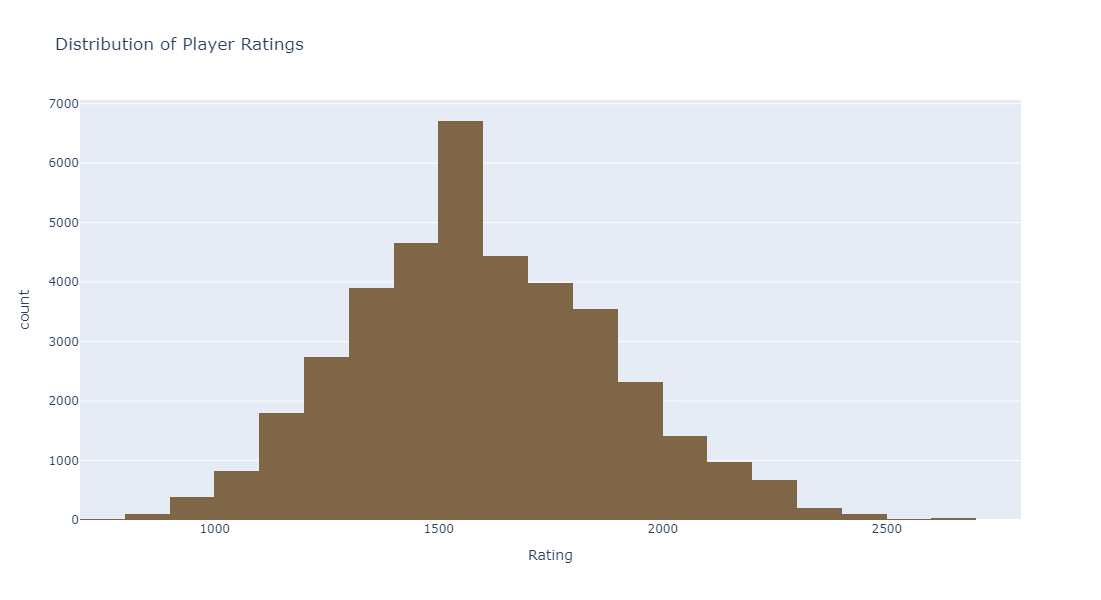

In [52]:
# Juntando ratings de preto e branco
ratings = pd.concat([df['white_rating'], df['black_rating']])  

# Histograma
fig = px.histogram(ratings, 
                   title='Distribution of Player Ratings',
                   labels={'value':'Rating'},
                   width=1000, height=600,
                   nbins=30,  # alterando número de bins para plotar valores de 100 em 100
                   color_discrete_sequence=[colorD]
                  )
# Removendo a legenda do gráfico
fig.update_layout(showlegend=False)

fig.show()

A distribuição dos ratings dos jogadores forma uma curva simétrica, com a maioria concentrada na faixa de 1500 a 1600. À medida que nos afastamos dessa faixa central, a frequência de jogadores diminui gradualmente, alcançando seus valores mais baixos em torno de 700 e mais altos em torno de 2700.

#### Rating do Vencedor é maior que do perdedor?

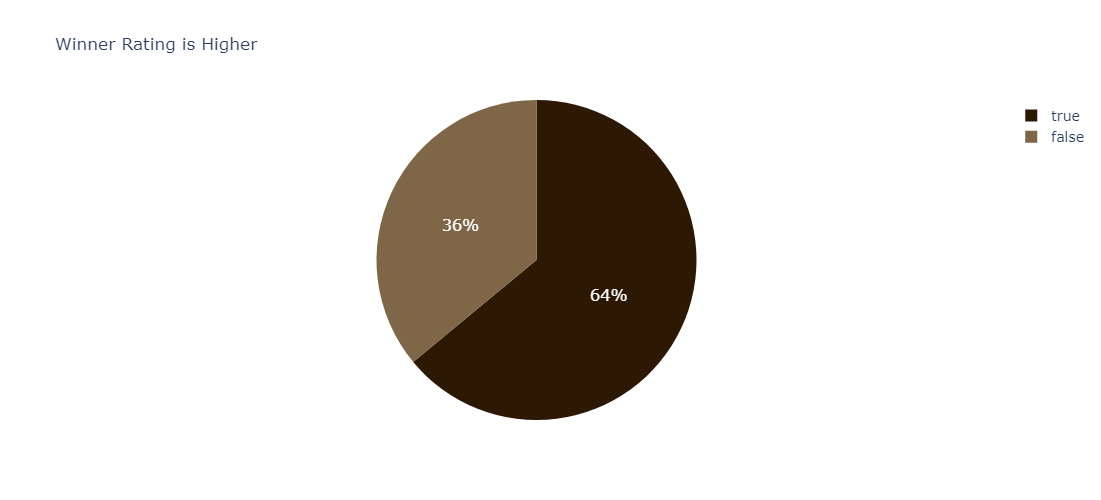

In [53]:
# Função para verificar as condições
def winner_rating_is_higher(row):
    if row['winner'] == 'white':
        return row['white_rating'] > row['black_rating']
    elif row['winner'] == 'black':
        return row['black_rating'] > row['white_rating']
    else:
        return None  # ou o que for apropriado para 'draw'

# Criando coluna com voleres de True ou False
df['winner_rating_is_higher'] = df.apply(lambda row: winner_rating_is_higher(row), axis=1)

# Calcular a distribuição percentual
winner_rating_counts = (df['winner_rating_is_higher'].value_counts(normalize=True) * 100).round()

# Criar o gráfico de pizza
fig = px.pie(values=winner_rating_counts.values, 
             names=winner_rating_counts.index, 
             title='Winner Rating is Higher',
             color_discrete_sequence=[colorB, colorD],
             width=500, height=500
            )
# Ajustar tamanho da fonte para valores e legenda
fig.update_traces(textfont_size=16, textinfo='percent')
fig.update_layout(legend_font_size=14)

fig.show()

A maioria das partidas (64%) resultou em vitória onde o rating do vencedor era superior ao do oponente, enquanto em 36% das partidas isso não ocorreu.

***
### Distribuição de quantidade de movimentos por partida

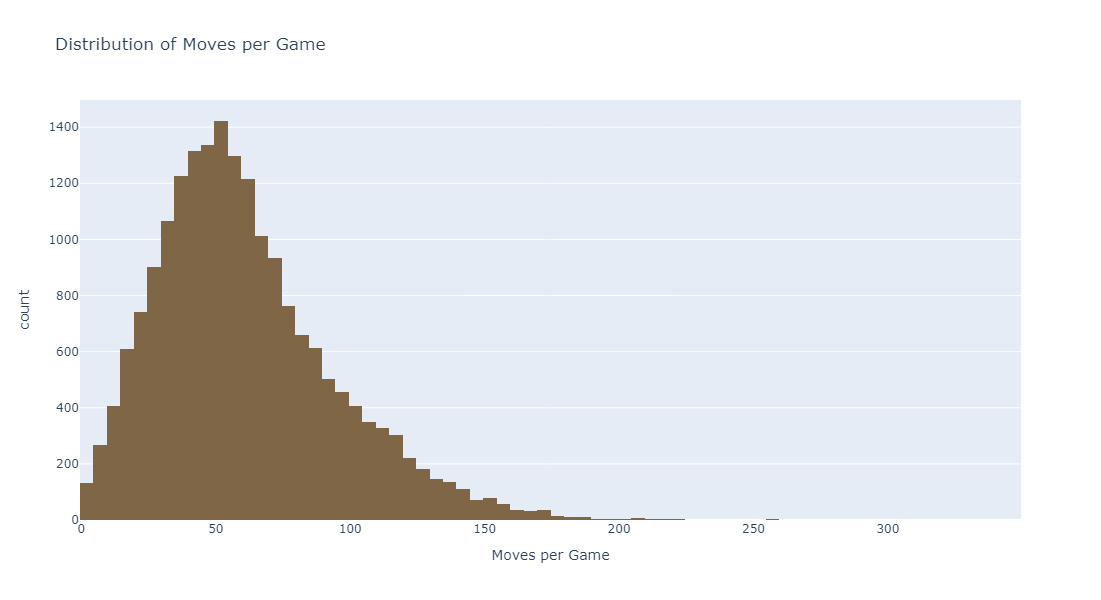

In [54]:
# calculando uma quantidade melhor de bins
nbins = int(np.sqrt(df.shape[0]))

# Histograma
fig = px.histogram(df['turns'], 
                   title='Distribution of Moves per Game',
                   labels={'value':'Moves per Game'},
                   width=1000, height=600,
                   nbins=nbins,
                   color_discrete_sequence=[colorD]
                  )
# Removendo a legenda do gráfico
fig.update_layout(showlegend=False)

fig.show()

A distribuição dos movimentos por partida forma uma curva assimétrica à direita. A maioria das partidas apresenta entre 30 e 70 movimentos, com uma diminuição gradual à medida que o número de movimentos aumenta, chegando a um número muito pequeno de partidas com mais de 250 movimentos.

***
### Distribuição de taxas de Vitória/Empate por Cor das peças

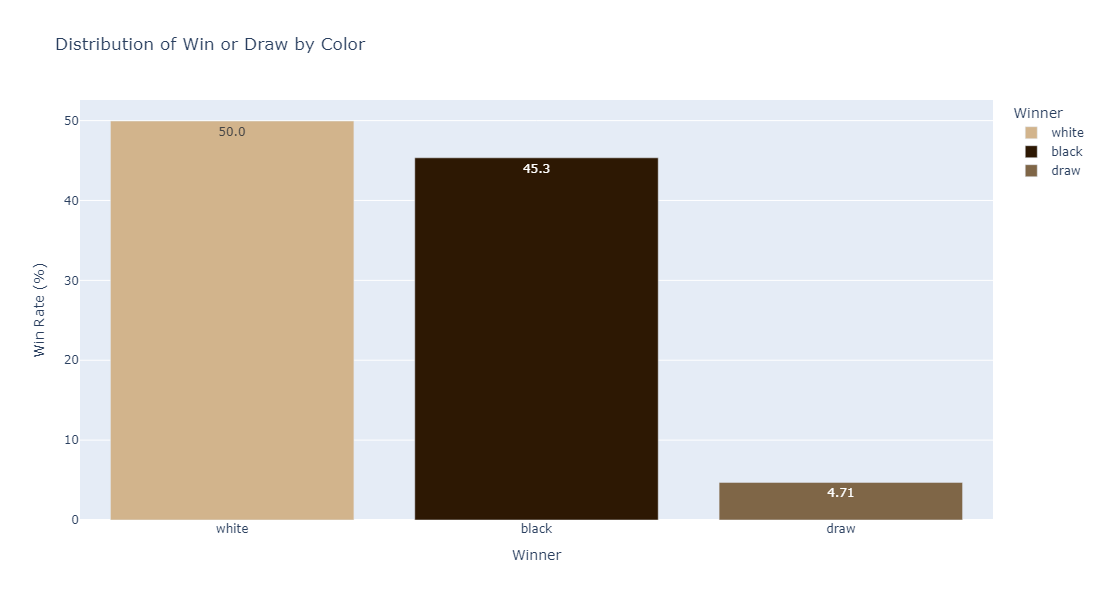

In [55]:
# Calculando a distribuição de vitórias por cor
count_winner_color = (df['winner'].value_counts(normalize=True)*100).round(2)

# Criando um DataFrame a partir da distribuição calculada
winner_color_df = count_winner_color.reset_index()
winner_color_df.columns = ['winner', 'proportion']

# Definindo as cores para cada categoria
color_map = {'white': colorW, 'black': colorB, 'draw': colorD}

# Gráfico de barras
fig = px.bar(winner_color_df,
             x='winner', y='proportion',
             width=1000, height=600,
             text_auto='.3s',
             title='Distribution of Win or Draw by Color',
             labels={'winner': 'Winner', 'proportion': 'Win Rate (%)'},
             color='winner',
             color_discrete_map=color_map)

fig.show()

A distribuição geral dos resultados das partidas mostra que quase metade das partidas são vencidas pelo jogador com as peças brancas, corroborando a vantagem teórica de jogar primeiro. As vitórias das peças pretas também são comuns, representando mais de 45% dos resultados, o que demonstra a capacidade dos jogadores em superar a vantagem inicial das brancas. Embora menos frequentes, os empates ainda ocorrem em uma porcentagem significativa das partidas, indicando que os jogadores frequentemente alcançam posições equilibradas onde nenhum dos lados pode forçar uma vitória. Esses insights fornecem uma visão clara da dinâmica dos resultados das partidas de xadrez e podem ajudar a entender melhor as estratégias envolvidas no jogo.

***
### Distribuição de como o jogo acabou (desistênica, cheque-mate, sem tempo, empate)

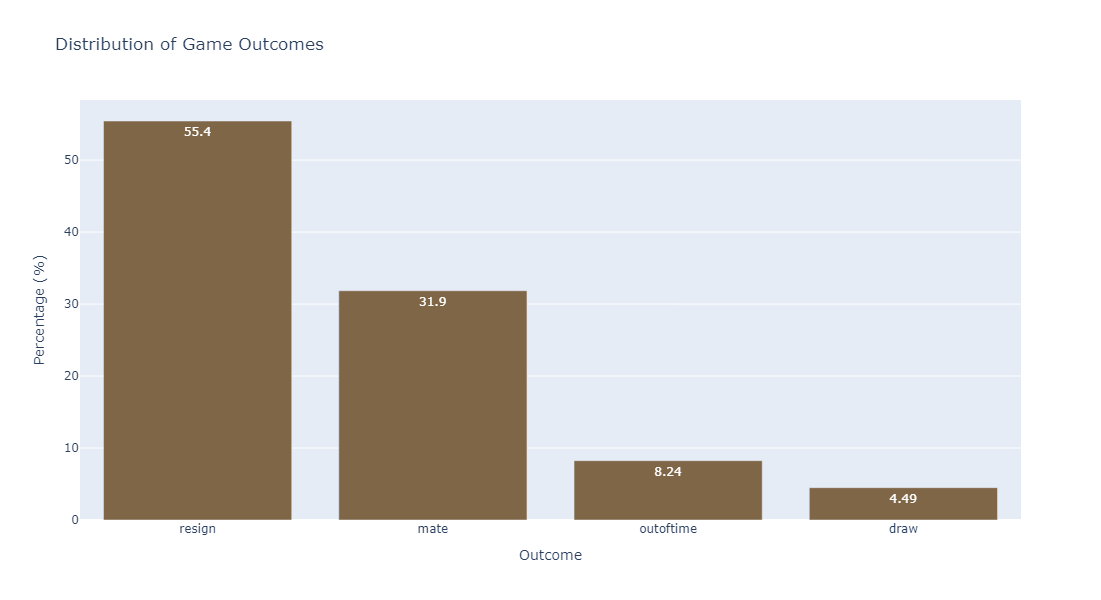

In [56]:
# Calculando a distribuição de status de vitória
count_victory_status = (df['victory_status'].value_counts(normalize=True) * 100).round(2)

# Criando um DataFrame a partir da distribuição calculada
victory_status_df = count_victory_status.reset_index()
victory_status_df.columns = ['victory_status', 'proportion']

# Gráfico de barras
fig = px.bar(victory_status_df,
             x='victory_status', y='proportion',
             width=1000, height=600, 
             text_auto='.3s',  # value on the bar
             title='Distribution of Game Outcomes',
             labels={'victory_status': 'Outcome', 'proportion': 'Percentage (%)'},
             color_discrete_sequence=[colorD])

fig.show()

A maioria dos jogos (55%) termina por desistência, o que é compreensível no xadrez, onde os jogadores frequentemente reconhecem quando estão em desvantagem e optam por desistir. Cerca de 32% das partidas terminam em xeque-mate, um resultado clássico que indica a vitória de um dos jogadores. Outros 8% dos jogos encerram-se devido à falta de tempo, um fator crucial no controle de tempo das partidas. Por fim, aproximadamente 4.5% das partidas terminam em empate, refletindo a igualdade de forças entre os jogadores.

***
### Formato das Partidas (bullet, blitz, rápida, clássica)

#### Definindo o formato

In [57]:
# Salvando somente tempo no cronômetro sem incrementos
df['increment_code'] = df['increment_code'].str.split('+').str[0].astype(int)

In [58]:
# valores em 'increment_code'
df['increment_code'].unique()

array([ 15,   5,  20,  30,  10,   8,  11,  18,  40,  16,   6,   7,  45,
        25,  12,   2,   9, 180,  17,   3,  60,  90,  14,   4,  13,  19,
         0,   1, 120,  35, 150,  29,  21])

In [59]:
# Definindo os bins e labels 
bins = [-1, 2, 6, 60, 180]
labels = ['Bullet', 'Blitz', 'Rapid', 'Classical']

# Criando a coluna 'game_type' definindo os tipos das partidas
df['game_type'] = pd.cut(df['increment_code'], bins=bins, labels=labels, right=True)
df['game_type'].unique()

['Rapid', 'Blitz', 'Bullet', 'Classical']
Categories (4, object): ['Bullet' < 'Blitz' < 'Rapid' < 'Classical']

#### Distribuição de 'game_type'

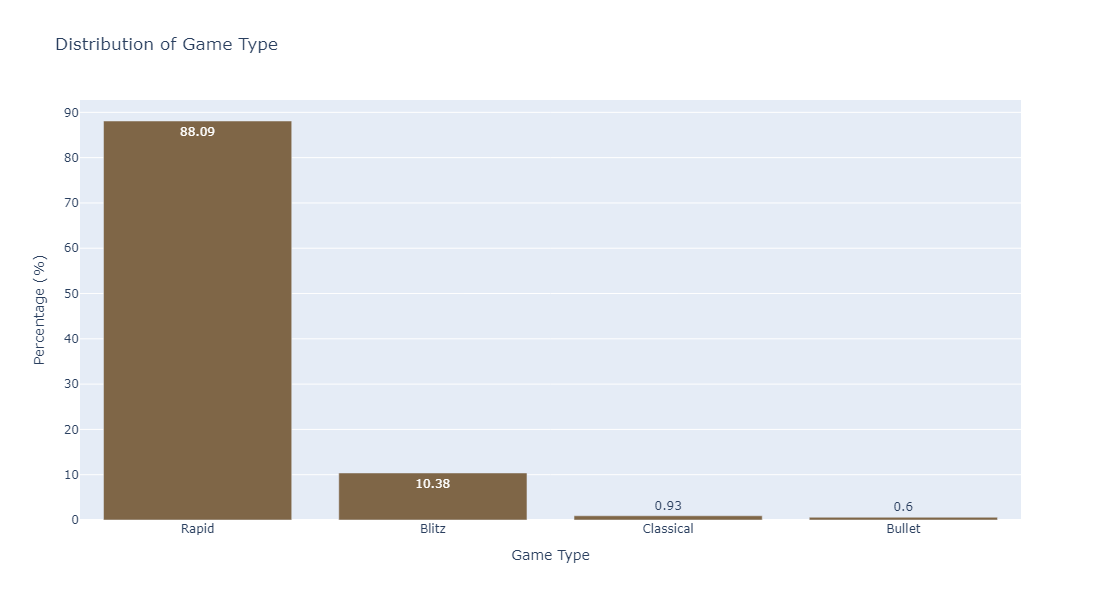

In [60]:
# Calculando a distribuição de tipo de partida
count_game_type = (df['game_type'].value_counts(normalize=True) * 100).round(2)
# Criando um DataFrame a partir da distribuição calculada
game_type_df = count_game_type.reset_index()

# Gráfico de barras
fig = px.bar(game_type_df,
             x='game_type', y='proportion',
             width=1000, height=600, 
             text='proportion',  # value on the bar
             title='Distribution of Game Type',
             labels={'game_type': 'Game Type', 'proportion': 'Percentage (%)'},
             color_discrete_sequence=[colorD])

fig.show()

A maior parte dos jogos no dataset são do tipo "Rápidas", representando 88% do total. Jogos do tipo "Blitz" constituem 10% do dataset, enquanto jogos "Clássicas" são apenas 0.9%. Finalmente, jogos "Bullet" representam a menor porcentagem, com apenas 0.6% do total. Esta distribuição sugere uma clara preferência por jogos mais rápidos entre os jogadores, mas não tão rápidos como são os Bullets.

#### Formato da partida vs Como terminou

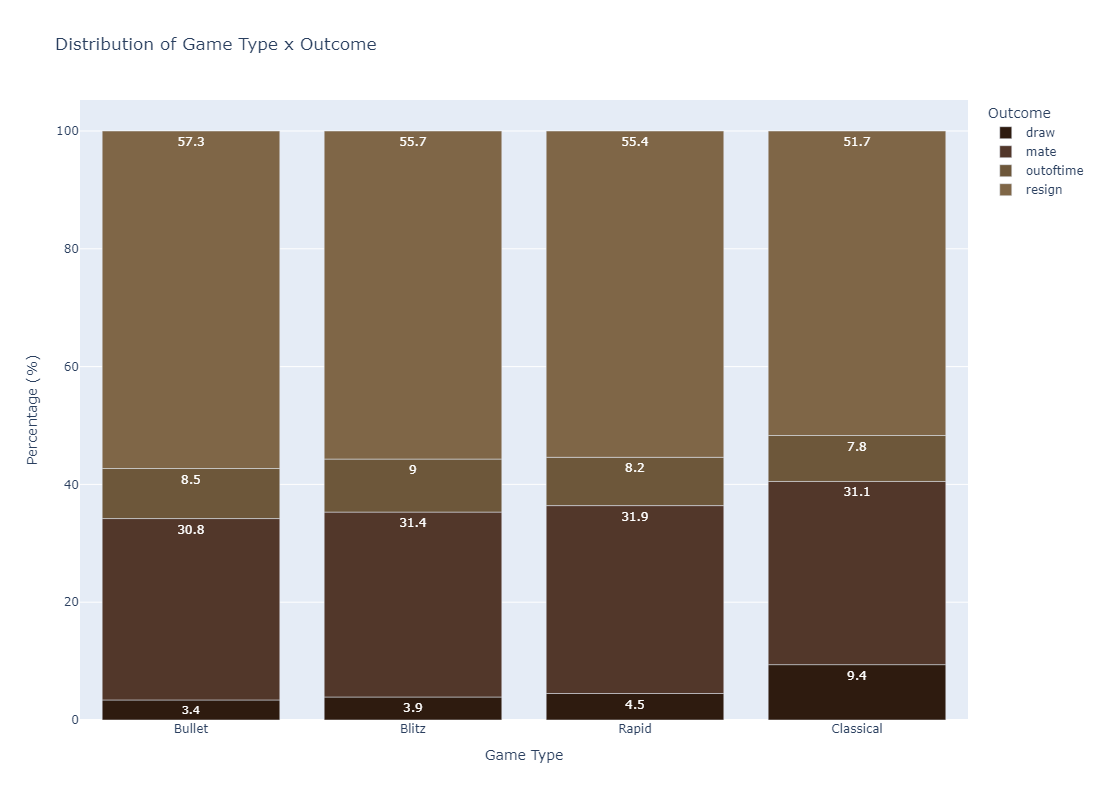

In [61]:
# Criando tabela cruzada para plot
cross_type_outcome = (pd.crosstab(df['game_type'], df['victory_status'], normalize='index') * 100).round(1)

# Gráfico de barras
fig = px.bar(cross_type_outcome,
             width=900, height=800, 
             text_auto=True,
             title='Distribution of Game Type x Outcome',
             labels={'game_type': 'Game Type', 
                     'victory_status': 'Outcome', 
                     'value': 'Percentage (%)'},
             color_discrete_sequence=wood_colors)

fig.show()

As desistências são a forma mais comum de encerramento em todos os tipos de jogos, especialmente em Bullet e Blitz, onde a pressão do tempo é mais alta. O xeque-mate é uma forma consistente de encerramento em todos os tipos de jogos, enquanto as partidas terminadas por tempo esgotado e por empate são mais comuns em jogos mais longos como Clássicos. A maior proporção de empates em jogos Clássicos destaca a profundidade estratégica e a capacidade dos jogadores de alcançar posições equilibradas.

***
### Níveis de Classificação

In [62]:
# Criando "Rating do Vencedor"
df['winner_rating'] = df.apply(lambda row: row['white_rating'] if row['winner'] == 'white' else
                                           row['black_rating'] if row['winner'] == 'black' else
                                           int((row['white_rating'] + row['black_rating']) / 2),
                               axis=1)

In [63]:
# Criando "Divisão de ratings dos vencedores"
bins = [0, 1000, 1400, 1800, 2200, 3000]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Expert', 'Master']
# labels = ['<1000', '1000-1399', '1400-1799', '1800-2199', '2200+']

# Criando winner_class
df['winner_class'] = pd.cut(df['winner_rating'], bins=bins, labels=labels)

#### Distribuição de níveis de classificação

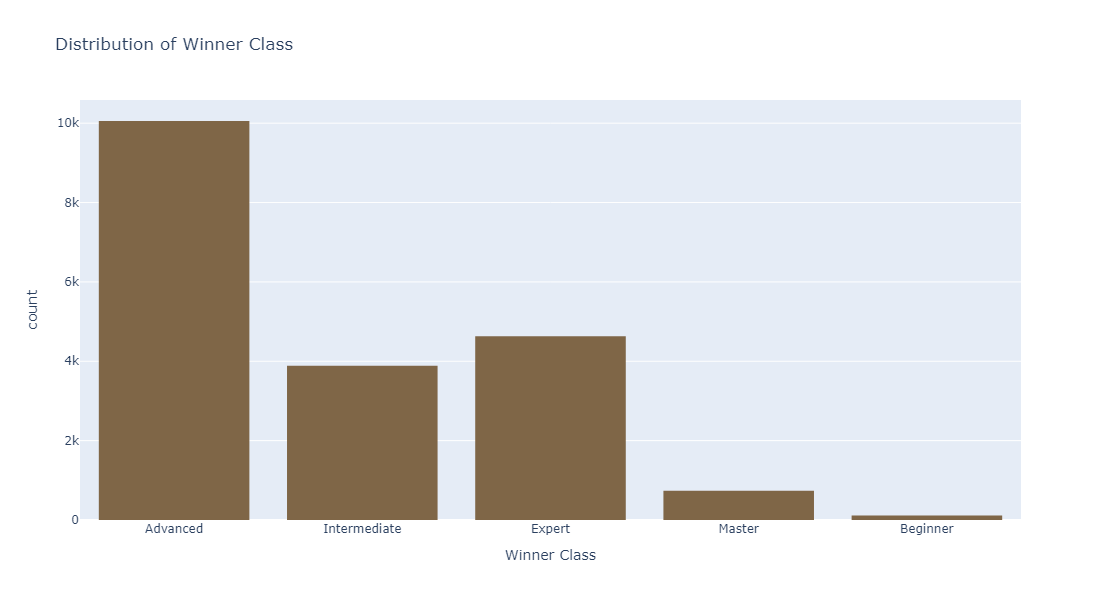

In [64]:
# Histograma
fig = px.histogram(df['winner_class'], 
                   title='Distribution of Winner Class',
                   labels={'value':'Winner Class'},
                   width=1000, height=600,
                   color_discrete_sequence=[colorD]
                  )
# Removendo a legenda do gráfico
fig.update_layout(showlegend=False)

fig.show()

A maior parte do nosso conjunto de dados é composta por jogos do nível Avançado, com uma porção significativa de partidas dos níveis Intermediário e Expert. O nível Master está representado em menor quantidade, e há bem poucos jogos de Iniciantes, totalizando ainda assim 115 partidas, o que é suficiente para nossas análises.

#### 'Rating do Vencedor é maior?' por 'Classe do vencedor'

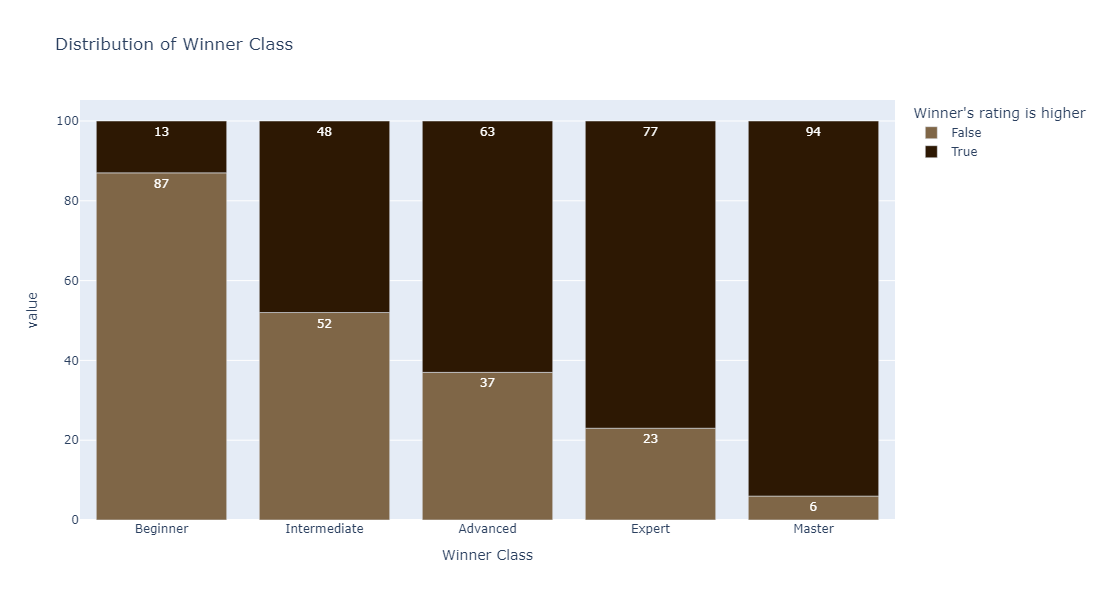

In [65]:
# Criando tabela
winner_rating_is_higher_by_class = df.groupby('winner_class', observed=True)['winner_rating_is_higher'].value_counts(normalize=True).unstack()

# Gráfico de barras
fig = px.bar((winner_rating_is_higher_by_class*100).round(), 
             title='Distribution of Winner Class',
             labels={'winner_class':'Winner Class',
                     'winner_rating_is_higher': "Winner's rating is higher"
                    },
             text_auto=True,
             width=800, height=600,
             color_discrete_sequence=[colorD, colorB]
            )

fig.show()

Observamos que a proporção de partidas onde o rating do vencedor é maior ('True') varia significativamente entre as diferentes classes de jogador. Nos níveis iniciante e intermediário, essa diferença não é tão evidente. No entanto, à medida que avançamos para classes superiores, como 'Advanced', 'Expert' e especialmente 'Master', a vantagem do rating mais alto se torna muito clara. Por exemplo, no nível 'Master', apenas 6% dos jogadores com rating inferior conseguiram vencer a partida.

#### Classe do vencedor por Cor da peça

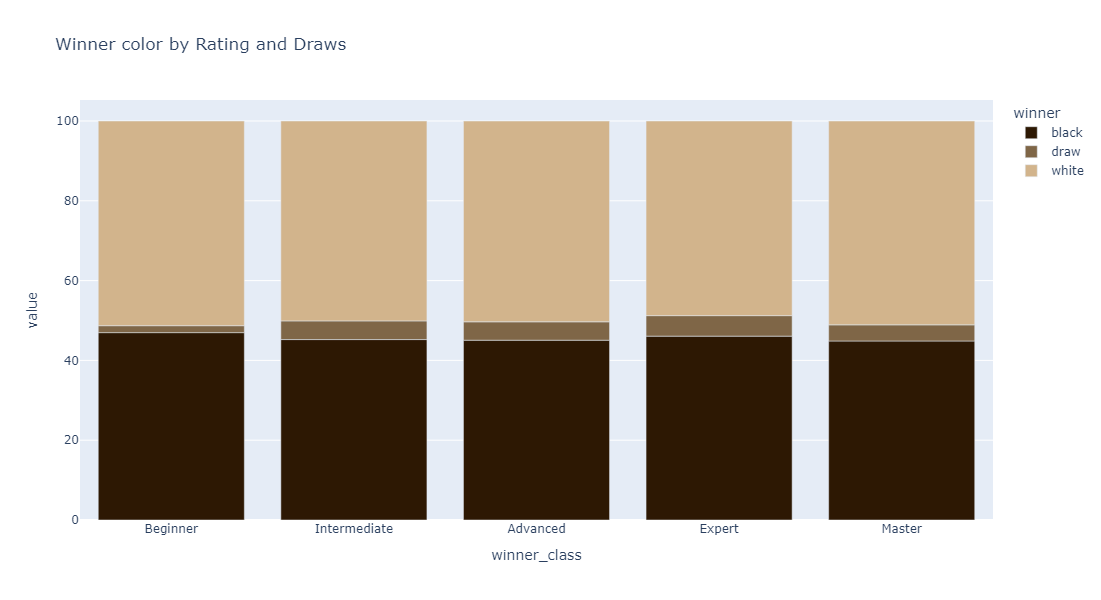

In [66]:
# tabela
win_class_by_color = df.groupby('winner_class', observed=True)['winner'].value_counts(normalize=True).unstack()

# plotando gráfico
px.bar((win_class_by_color*100).round(2),
       title='Winner color by Rating and Draws',
       width=800, height=600, 
       # cores
       color='winner', 
       color_discrete_sequence=[colorB, colorD, colorW])

A tendência geral mostra uma ligeira vantagem para as vitórias com as peças brancas em todas as classes, o que pode ser atribuído à vantagem inicial de jogar primeiro. A taxa de empates aumenta conforme a habilidade dos jogadores melhora, especialmente entre especialistas, refletindo uma maior capacidade de evitar derrotas. No entanto, entre os mestres, a taxa de empates diminui ligeiramente, indicando que a habilidade superior frequentemente leva a resultados decisivos, independentemente da cor das peças. Esses insights ajudam a entender melhor como a habilidade dos jogadores influencia os resultados das partidas de xadrez.

***
### Analisando Aberturas

In [67]:
# Calculando as 10 aberturas mais usadas em porcentagem
top_openings = pd.DataFrame(df['opening_name'].value_counts(normalize=True) * 100).round(2).head(10)
# Renomeando a coluna de valores para nao aparecer
top_openings.columns = ['']
# Renomeando a coluna índice para aparecer como um título da tabela
top_openings.index.name = 'Top 10 Aberturas mais utilizadas (%)'

top_openings

,
Top 10 Aberturas mais utilizadas (%),
Sicilian Defense,1.77
Van't Kruijs Opening,1.73
Sicilian Defense: Bowdler Attack,1.51
French Defense: Knight Variation,1.36
Scotch Game,1.36
Scandinavian Defense: Mieses-Kotroc Variation,1.30
Italian Game: Two Knights Defense,1.23
Queen's Pawn Game: Mason Attack,1.18
Queen's Pawn Game: Chigorin Variation,1.15


### Aberturas com maior taxa de sucesso (Brancas x Pretas x Empate)

In [68]:
# filtrando aberturas que possuem somente mais de 30 dados
openings30 = df['opening_name'].value_counts() > 30
openings30 = openings30[openings30].index
openings30_df = df[df['opening_name'].isin(openings30)]
# agrupando aberturas por vencedor
openings_group_by_winner = (openings30_df.groupby('opening_name')['winner'].value_counts(normalize=True)*100).round(2).unstack()

# melhores aberturas para brancas
best_openings_white = openings_group_by_winner.sort_values(by='white', ascending=False).head(5)
# melhores aberturas para pretas
best_openings_black = openings_group_by_winner.sort_values(by='black', ascending=False).head(5)
# aberturas com mais empates
best_openings_draw = openings_group_by_winner.sort_values(by='draw', ascending=False).head(5)

# cores para os gráficos
opening_colors = [colorB, colorD, colorW]

#### Melhores aberturas para Brancas

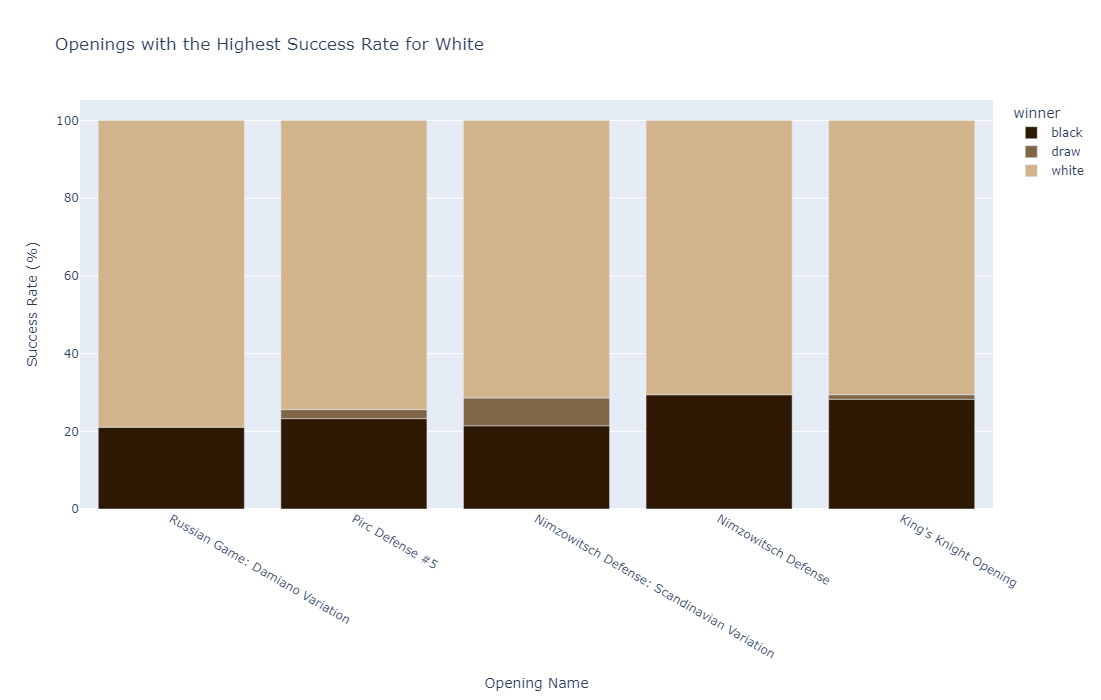

In [69]:
# Plot das aberturas com a maior taxa de sucesso para peças brancas
fig = px.bar(best_openings_white, 
             title='Openings with the Highest Success Rate for White',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

#### Melhores Aberturas para Pretas

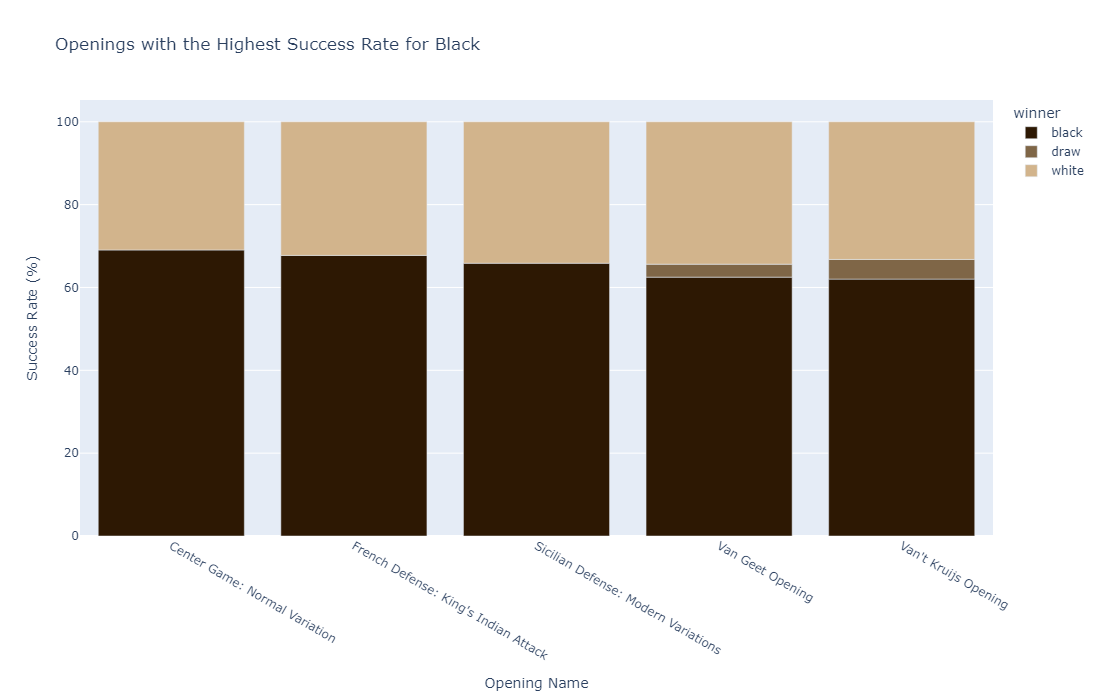

In [70]:
# Plot das aberturas com a maior taxa de sucesso para peças pretas
fig = px.bar(best_openings_black, 
             title='Openings with the Highest Success Rate for Black',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

#### Aberturas com mais chance de empate

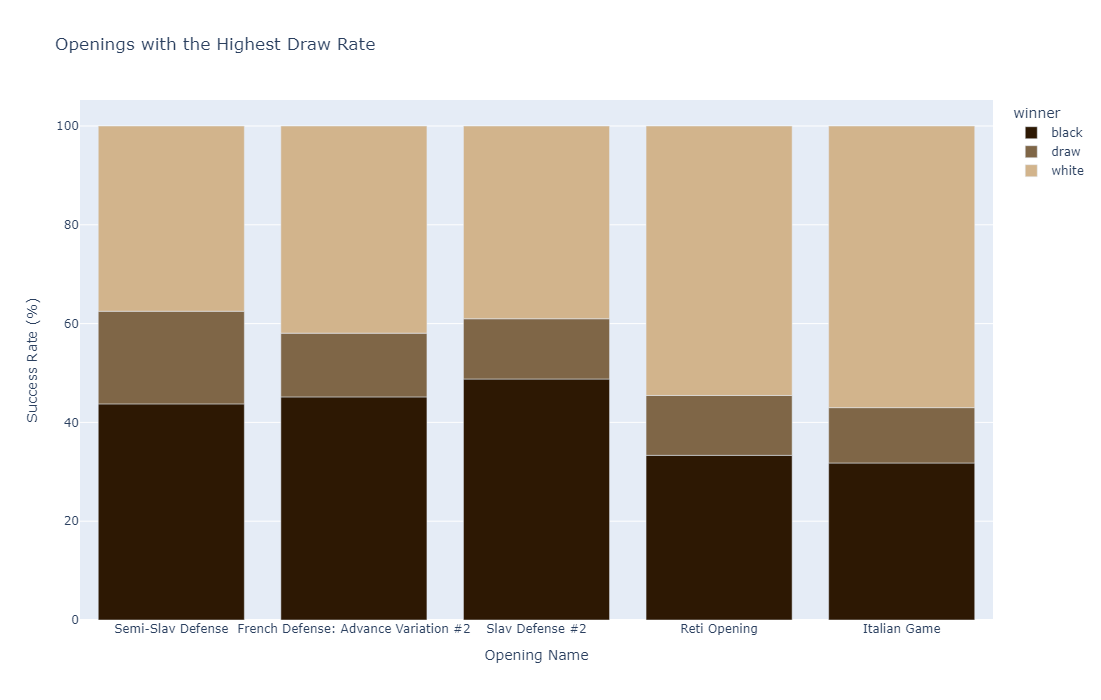

In [71]:
# Plot das aberturas com a maior taxa de empate
fig = px.bar(best_openings_draw, 
             title='Openings with the Highest Draw Rate',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

* A abertura com a maior taxa de sucesso para as Brancas é a "Russian Game: Damiano Variation", que em nosso conjunto de dados apresenta quase 80% de vitórias para as Brancas, seguida por outras aberturas também com altas taxas de sucesso.
* A abertura com a maior taxa de sucesso para as Pretas é a "Center Game: Normal Variation", que em nosso conjunto de dados apresenta quase 70% de vitórias para as Pretas, seguida por outras aberturas também com altas taxas de sucesso.
* A abertura com a maior taxa de empates é a "Semi-Slav Defense", que em nosso conjunto de dados apresenta quase 20% de empates, seguida por outras aberturas também com altas taxas de empate.

Concluímos que a escolha da abertura tem um impacto significativo nos resultados das partidas.

***
### Quantidade de Lances de Abertura

In [72]:
# Criando as etiquetas e os bins para a quantidade de movimentos na abertura
bins = list(range(1, 28, 3)) 
bins.append(28)  # Adiciona o último limite para incluir 27
labels = [f'{i} - {i+2}' for i in range(1, 27, 3)]  # '1-3', '4-6', ..., '25-27'

# Criando a coluna 'cut_opening_ply' no DataFrame 'df'
df['cut_opening_ply'] = pd.cut(df['opening_ply'], bins=bins, labels=labels, right=True, include_lowest=True)

# Calculando a distribuição percentual por classe de vencedor
qtd_opening_moves_by_class = (
    df.groupby('winner_class', observed=False)['cut_opening_ply']
    .value_counts(normalize=True)
    .unstack() * 100
).round(2)

#### 'Quantidade de Lances de Abertura' por 'Classe do Vencedor'

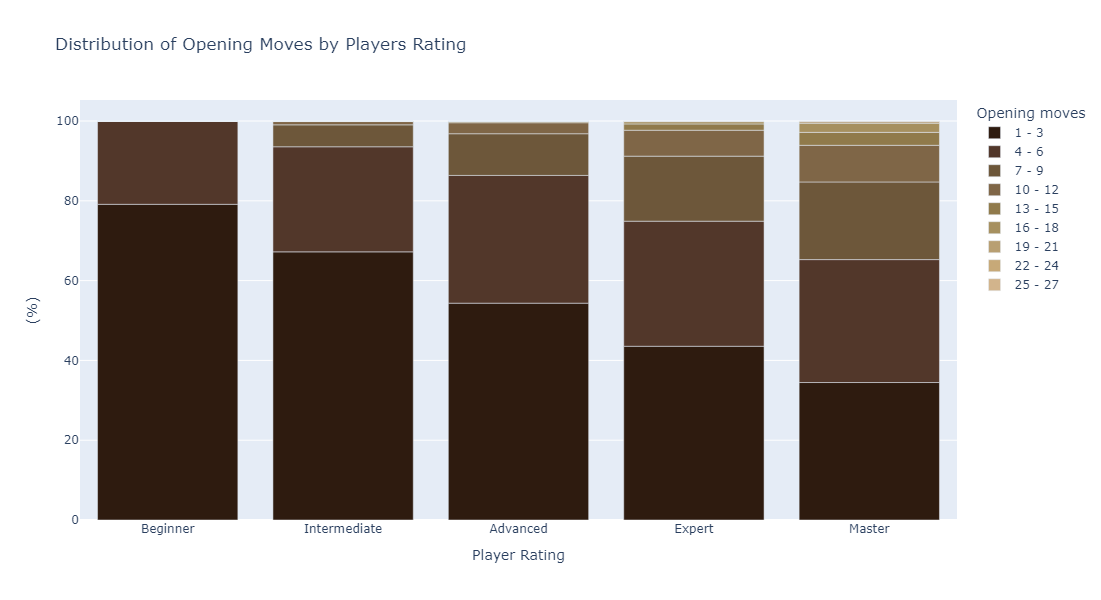

In [73]:
# Gráfico de barras
fig = px.bar(qtd_opening_moves_by_class,
             title='Distribution of Opening Moves by Players Rating',
             width=800, height=600,
             color_discrete_sequence=wood_colors,
             labels={'winner_class': 'Player Rating', 
                     'value':'(%)', 
                     'cut_opening_ply': 'Opening moves'}
            )

fig.show()

Podemos perceber claramente que, quanto mais alto o nível dos jogadores, mais lances de abertura eles tendem a executar. Isso ocorre porque jogadores de níveis mais avançados possuem um conhecimento mais profundo das aberturas e das linhas teóricas, permitindo-lhes planejar com maior precisão e profundidade desde o início da partida.

***
### Turnos por partida

In [74]:
# Criando "Divisão de turnos na partida"
bins = [0, 20, 50, 100, 150, 350]
labels = ['3-20', '21-50', '51-100', '101-150', '150-350']

# Criando turns_cut
df['turns_cut'] = pd.cut(df['turns'], bins=bins, labels=labels)

#### Quantidade de Turnos por Classe do vencedor

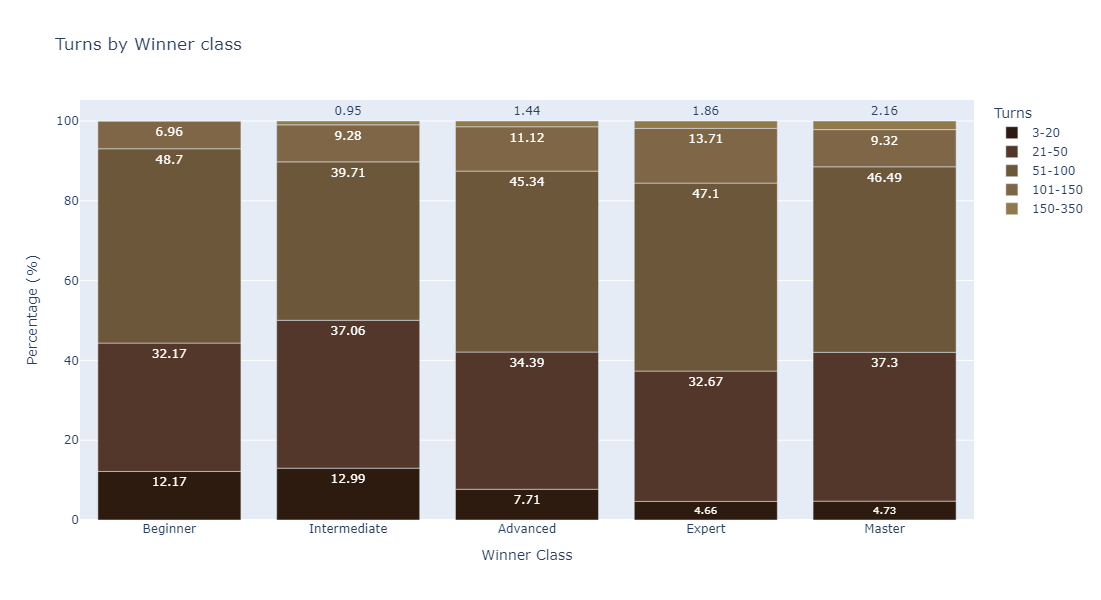

In [75]:
# tabela
turns_cut_by_class = df.groupby('winner_class', observed=True)['turns_cut'].value_counts(normalize=True).unstack()

# plotando gráfico
px.bar((turns_cut_by_class*100).round(2),
       title='Turns by Winner class',
       width=800, height=600, 
       labels={'turns_cut': 'Turns', 
               'winner_class': 'Winner Class', 
               'value': 'Percentage (%)'},
       text_auto='',
       color_discrete_sequence=wood_colors
      )

Iniciantes tendem a ter partidas mais curtas e erráticas, enquanto jogadores mais experientes e mestres demonstram um equilíbrio entre tática e estratégia, frequentemente resultando em jogos mais longos e complexos. Esses insights podem ajudar a entender melhor o progresso e as características de jogo em diferentes níveis de habilidade no xadrez.

#### Quantidade de Turnos por Tipo de Partida

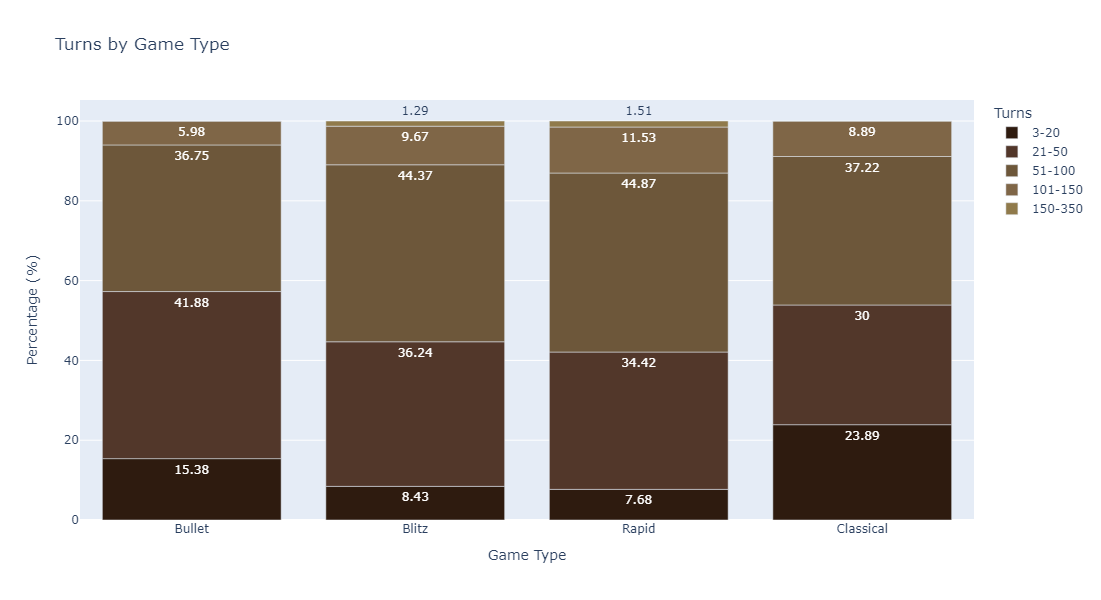

In [76]:
# tabela
turns_cut_by_type = df.groupby('game_type', observed=True)['turns_cut'].value_counts(normalize=True).unstack()

# plotando gráfico
px.bar((turns_cut_by_type*100).round(2),
       title='Turns by Game Type',
       width=800, height=600, 
       labels={'turns_cut': 'Turns', 
               'game_type': 'Game Type', 
               'value': 'Percentage (%)'},
       text_auto='',
       color_discrete_sequence=wood_colors
      )

As partidas Bullet, devido à sua natureza extremamente rápida, tendem a ser mais curtas, com uma concentração significativa de jogos em faixas de movimentos menores. As partidas Blitz e Rapid, apesar de rápidas, permitem um desenvolvimento mais completo dos jogos, resultando em uma maior porcentagem de partidas na faixa de 51-100 movimentos. As partidas Classical, por outro lado, mostram uma variabilidade maior, com uma notável quantidade de jogos terminando rapidamente, possivelmente devido à desistência ou a erros graves no início. Esses insights ajudam a entender melhor as dinâmicas e características dos diferentes tipos de jogos de xadrez.

## Conclusão